In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

2024-11-26 20:50:46.114426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 20:50:48.002580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732672248.330023  379263 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732672248.466884  379263 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 20:50:49.351366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set paths
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1"
dataset_path = tf.keras.utils.get_file('ls_model_data_five.zip', origin=dataset_url, extract=True)
extracted_dir = os.path.splitext(dataset_path)[0]



2827545895/2827545895 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 with pre-trained ImageNet weights (without the top classification layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create the model by adding custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # For binary classification (landslide vs non-landslide)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


I0000 00:00:1732672351.329707  379263 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31027 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

extracted_dir = '/home/mjp2da/.keras/datasets/ls_model_data_five_extracted'
train_dir = os.path.join(extracted_dir, 'train')
val_dir = os.path.join(extracted_dir, 'validation')
test_dir = os.path.join(extracted_dir, 'test')


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_dir = '/home/rrm3nh/.keras/datasets/ls_model_data_five_extracted'
# Create ImageDataGenerators with validation split
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% for validation
)

# Train generator with validation split
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Specifies this is the training subset
)

# Validation generator with validation split
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specifies this is the validation subset
)


Found 5580 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.


In [6]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1732674374.004024  379521 service.cc:148] XLA service 0x7f7b64021f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732674374.004089  379521 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-11-26 21:26:14.327283: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732674375.102955  379521 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5625 - loss: 1.223737

I0000 00:00:1732674379.742009  379521 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9053 - loss: 0.2676

/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9056 - loss: 0.2668 - val_accuracy: 0.5430 - val_loss: 1.3623
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 101s 576ms/step - accuracy: 0.9783 - loss: 0.0598 - val_accuracy: 0.5545 - val_loss: 1.9051
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 101s 575ms/step - accuracy: 0.9860 - loss: 0.0405 - val_accuracy: 0.5552 - val_loss: 2.1320
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 101s 576ms/step - accuracy: 0.9812 - loss: 0.0662 - val_accuracy: 0.5359 - val_loss: 2.3588
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 101s 575ms/step - accuracy: 0.9876 - loss: 0.0321 - val_accuracy: 0.5538 - val_loss: 1.8603
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 100s 574ms/step - accuracy: 0.9860 - loss: 0.0514 - val_accuracy: 0.5509 - val_loss: 2.2576
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 100s 571ms/step - accuracy: 0.9837 - loss: 0.0498 - val_accuracy: 0.5524 - val_loss: 2.0402
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 100s 570ms/step - accuracy: 0.9896 - loss: 0.0325 

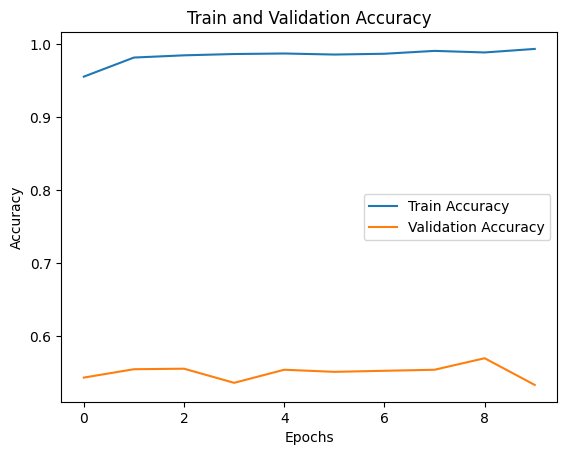

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
model_save_path = '/home/rrm3nh/.keras/models/mobilenetv2_landslide_model.h5'

# Save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}.")

Model saved to /home/rrm3nh/.keras/models/mobilenetv2_landslide_model.h5.


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

In [11]:
# Download and extract the test dataset
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"
test_dataset_path = tf.keras.utils.get_file('test_google_images_landslide_three.zip', origin=test_dataset_url, extract=True)
test_extracted_dir = os.path.splitext(test_dataset_path)[0]

# Check test dataset structure
print(f"Test dataset extracted to: {test_extracted_dir}")

79971293/79971293 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Test dataset extracted to: /home/rrm3nh/.keras/datasets/test_google_images_landslide_three_extracted


In [12]:
import os
test_extracted_dir = '/home/rrm3nh/.keras/datasets/test_google_images_landslide_three_extracted'
print(os.listdir(test_extracted_dir))

['Google_Earth_Images']


In [13]:
test_dir = os.path.join(test_extracted_dir, 'Google_Earth_Images')

In [14]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # For binary classification, adjust if multi-class
    shuffle=False  # Ensure test data is not shuffled for evaluation
)

Found 114 images belonging to 2 classes.


In [15]:
from tensorflow.keras.models import load_model
model = load_model(model_save_path)

print("Model loaded successfully.")

Model loaded successfully.


In [16]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step - accuracy: 0.3729 - loss: 8.1150
Test Loss: 5.400904178619385
Test Accuracy: 57.02%


In [17]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 874ms/step


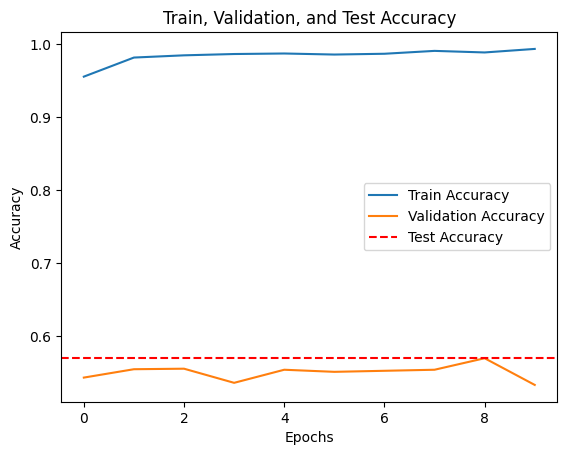

In [18]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Train, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import confusion_matrix
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

Confusion Matrix:
[[ 0 47]
 [ 2 65]]


NameError: name 'classification_report' is not defined

In [ ]:
filenames = test_generator.filenames
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    random_idx = np.random.randint(0, len(filenames))
    img_path = os.path.join(test_dir, filenames[random_idx])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    true_label = "Landslide" if true_classes[random_idx] == 1 else "Non-Landslide"
    pred_label = "Landslide" if predicted_classes[random_idx] == 1 else "Non-Landslide"
    plt.title(f"True: {true_label}\nPred: {pred_label}")

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow import keras

## Helper Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(factor=0.4),
    # layers.RandomSaturation(.7, seed=516) ## Error
    layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.1, upper=1))
  ]
)

In [ ]:
IMG_SIZE=224

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ### Adding Augmentation
inputs = data_augmentation(inputs)  ## Added Line

# Load MobileNetV2 with pre-trained ImageNet weights (without the top classification layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the base model
base_model.trainable = False

# Create the model by adding custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # For binary classification (landslide vs non-landslide)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

## Images that we are using Grad CAM on:

In [26]:
import pathlib
data_dir = tf.keras.utils.get_file('ls_model_data_five_extracted.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [27]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6974


In [28]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide


In [30]:
import PIL

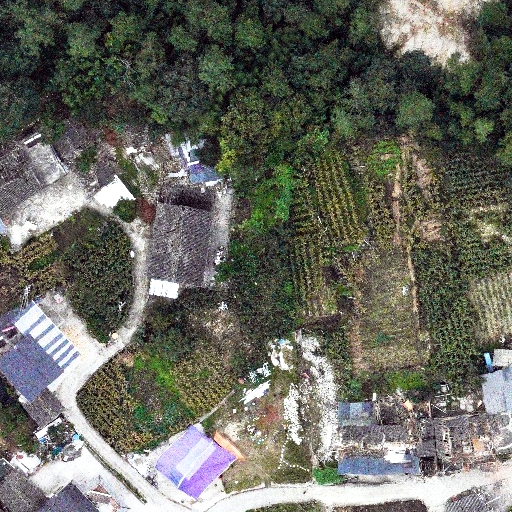

In [31]:
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[0]))

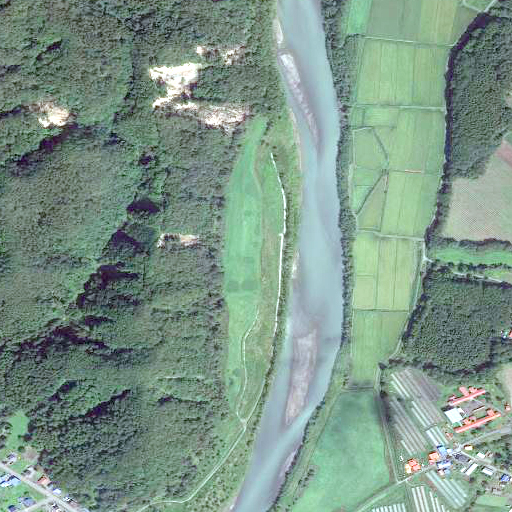

In [37]:
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[4]))

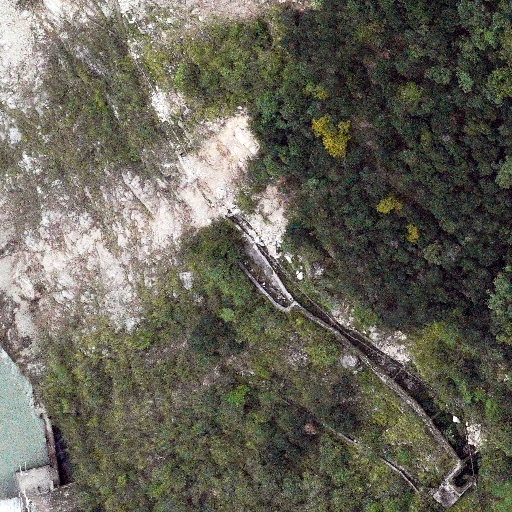

In [39]:
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[6]))

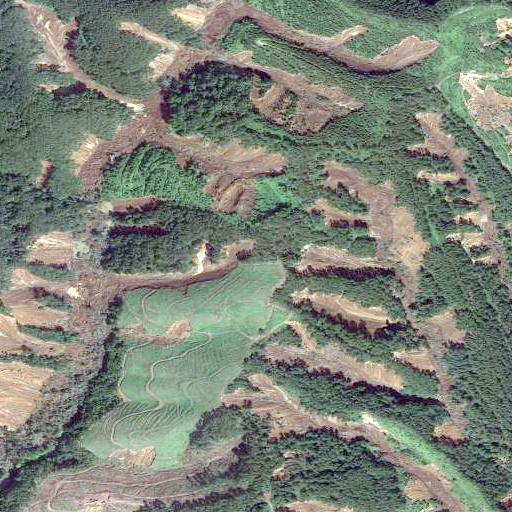

In [42]:
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[9]))

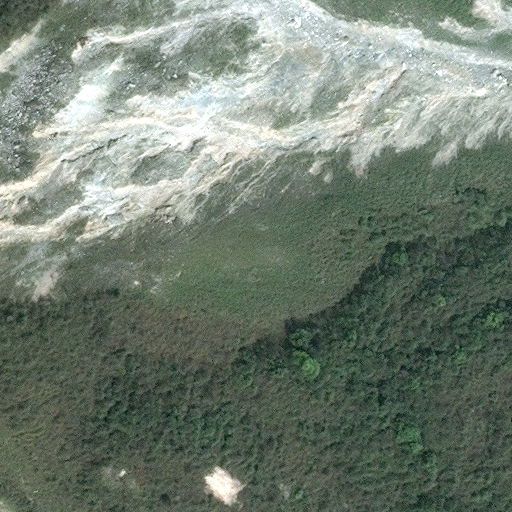

In [48]:
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[15]))

In [49]:
## Load Image
landslide_img_one_url = "https://dl.dropboxusercontent.com/scl/fi/viovy9pcma2y6hq58ntns/NASA_GoogE_14445.jpg?rlkey=ltitymrzuarrxxogge32c1kbi&dl=0?raw=1"
landslide_img_one_path = tf.keras.utils.get_file('NASA_GoogE_14445', origin=landslide_img_one_url)

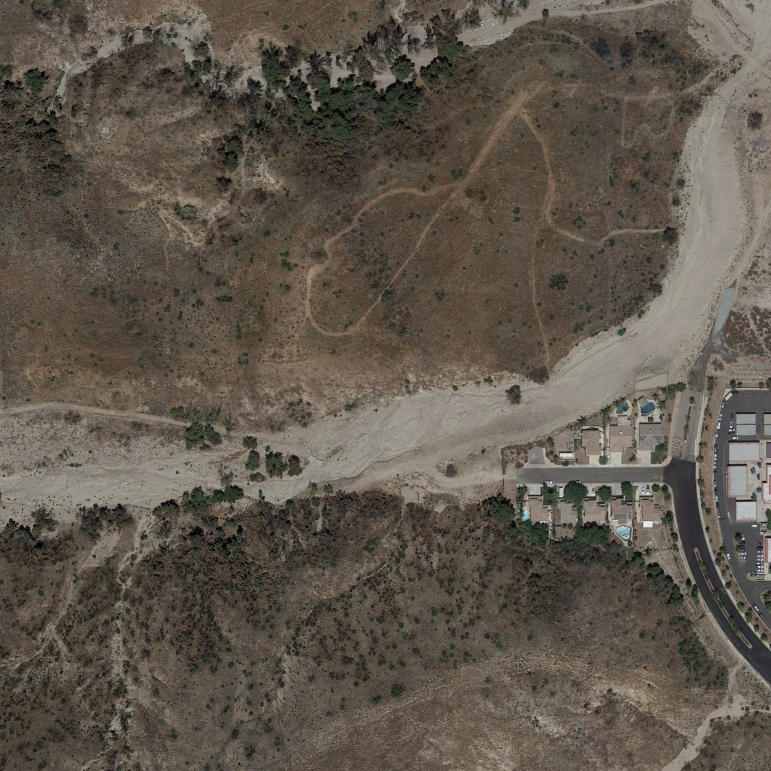

In [52]:
PIL.Image.open(landslide_img_one_path)

In [61]:
from tensorflow import keras
from tensorflow.keras.models import clone_model
from IPython.display import Image, display
import matplotlib as mpl
import numpy as np

In [54]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name,last_deep_layer_name,pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.get_layer(last_deep_layer_name).output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,570,755 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [63]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

model_clone = clone_model(model) #cloning so we can leave the original one intact
model_clone.layers[-1].activation = None #turn activation off for the last prediction layer
last_conv_layer_name = " " #take the last convolutional layer
last_deep_layer_name = "dropout"


In [64]:
img_size = (300, 300)

img_array = preprocess_input(get_img_array(landslide_one[0], size=img_size))

preds = model_clone.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_clone, last_conv_layer_name,last_deep_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "mobilenetv2_1.00_224" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 300, 300, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 300, 300, 3), dtype=float32)
  • training=False
  • mask=None